In [3]:
import pandas as pd
import os
import networkx as nx
import itertools
from netwulf import visualize
import netwulf as nw
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib

In [4]:
author_df = pd.read_csv(r"C:\Users\mansj\IQL\salt\data\salt_cont_author.csv")
article_list = pd.read_csv(r"C:\Users\mansj\IQL\salt\data\article_list.csv")

In [5]:
author_df.head()

,ID,title,author_given_name,author_surname,author_id,organizational_author,manual
0,1,Systematic review of long term effects of advi...,Lee,Hooper,57202855325,NaN,False
1,1,Systematic review of long term effects of advi...,Christopher,Bartlett,57194377301,NaN,False
2,1,Systematic review of long term effects of advi...,George Davey,Smith,35354080500,NaN,False
3,1,Systematic review of long term effects of advi...,Shah,Ebrahim,7102093023,NaN,False
4,2,Reduced dietary salt for prevention of cardiov...,L.,Hooper,57202855325,NaN,False


In [6]:
article_list.head()

,ID,short_name,type,study_groupings,title,year,attitude,doi,retracted(Y/N),study_design
0,1,Hooper2002,Systematic Review,NaN,Systematic review of long term effects of advi...,2002,inconclusive,10.1136/bmj.325.7365.628,NaN,Systematic Review
1,2,Hooper2003,Systematic Review,NaN,Reduced dietary salt for prevention of cardiov...,2003,inconclusive,10.1002/14651858.CD003656,NaN,Systematic Review
2,3,Hooper2004,Systematic Review,NaN,Advice to reduce dietary salt for prevention o...,2004,inconclusive,10.1002/14651858.CD003656.pub2,NaN,Systematic Review
3,4,Strazzullo2009,Systematic Review,NaN,"Salt intake, stroke, and cardiovascular diseas...",2009,for,10.1136/bmj.b4567,NaN,Systematic Review
4,5,Taylor2011a,Systematic Review,NaN,Reduced dietary salt for the prevention of car...,2011,inconclusive,10.1038/ajh.2011.115,NaN,Systematic Review


In [7]:
author_df["full_name"] = author_df['author_given_name'] + " " + author_df['author_surname'].fillna('')
author_df.head()
com_df = pd.DataFrame(author_df.groupby('ID')['full_name'].apply(list))
com_df.head()

,full_name
ID,
1,"[Lee Hooper, Christopher Bartlett, George Dave..."
2,"[L. Hooper, C. Bartlett, G. Davey Smith, S. Eb..."
3,"[Lee Hooper, Christopher Bartlett, George Dave..."
4,"[Pasquale Strazzullo, Lanfranco D'Elia, Ngiang..."
5,"[Rod S. Taylor, Kate E. Ashton, Tiffany Moxham..."


In [8]:
list_authors  = pd.DataFrame(author_df.groupby('author_id')['full_name'].apply(list))
auth_list = list_authors.full_name.to_list()

auth_dict = dict()

for i in auth_list:
    i = list(set(i))
    if len(i) > 1:
        auth_dict[i[0]] = i[1:]

#### Function replaces the names of author with same id with the selected key in the dictionary
def replace(auth_name, final_dict):
    for k, v in final_dict.items():
        if auth_name in v:
            auth_name = k
            
    return auth_name
    

author_df.full_name = author_df.full_name.apply(lambda x : replace (x, auth_dict))

In [9]:
author_df[author_df.author_id == 57202855325]

,ID,title,author_given_name,author_surname,author_id,organizational_author,manual,full_name
0,1,Systematic review of long term effects of advi...,Lee,Hooper,57202855325,NaN,False,L. Hooper
4,2,Reduced dietary salt for prevention of cardiov...,L.,Hooper,57202855325,NaN,False,L. Hooper
8,3,Advice to reduce dietary salt for prevention o...,Lee,Hooper,57202855325,NaN,False,L. Hooper
19,5,Reduced dietary salt for the prevention of car...,Lee,Hooper,57202855325,NaN,False,L. Hooper
27,9,Effect of lower sodium intake on health: syste...,Lee,Hooper,57202855325,NaN,False,L. Hooper
449,6,Reduced dietary salt for the prevention of car...,Lee,Hooper,57202855325,NaN,False,L. Hooper


In [13]:
merged_type_df = pd.merge(com_df, article_list, how = "inner", left_on="ID", right_on="ID")
merged_type_df = merged_type_df[["ID", "full_name","title", "type",]]
merged_type_df.rename(columns={"Our ID":"ID", "type":"item_type", "Title" :"title"}, inplace=True)

new  = []
for i in range(1,len(merged_type_df["ID"])):
    name = merged_type_df["full_name"].loc[i]
    type_t = merged_type_df["item_type"].loc[i]
    if len(name) >= 2:
        for subset in itertools.combinations(name,2):
            if len(subset) == 2:
                new.append({"auth":subset, "type":type_t})
                
df = pd.DataFrame(new)

In [68]:
new  = {}
r_count = 0
i_count = 0
for i in range(1,len(merged_type_df)):
    name = merged_type_df["full_name"].loc[i]
    type_t = merged_type_df["item_type"].loc[i]
    if type_t == "Systematic Review":
        r_count = 1
    else:
        i_count = 1
    if len(name) >= 2:
        for subset in itertools.combinations(name,2):
            if len(subset) == 2:
                
                subset = tuple(sorted(subset))
                
                if subset not in new.keys():
                    new[subset] = (r_count, i_count)
                else:
                    new[subset] = (new[subset][0] + r_count, new[subset][1] + i_count)
                    
#                 new.append({"auth":subset, "type":type_t})

In [69]:
df = pd.DataFrame(new.items(), columns=['authors','counts'])
df[['reviews', 'included']] = pd.DataFrame(df['counts'].tolist(), index=df.index)
df[['auth_1', "auth_2"]] = pd.DataFrame(df['authors'].tolist(), index = df.index)
df['total'] = df['reviews'] + df['included']
df['review_percent'] = round(df['reviews']/df['total'] ,3)
df

,authors,counts,reviews,included,auth_1,auth_2,total,review_percent
0,"(C. Bartlett, L. Hooper)","(1, 0)",1,0,C. Bartlett,L. Hooper,1,1.0
1,"(G. Davey Smith, L. Hooper)","(1, 0)",1,0,G. Davey Smith,L. Hooper,1,1.0
2,"(L. Hooper, S. Ebrahim)","(1, 0)",1,0,L. Hooper,S. Ebrahim,1,1.0
3,"(C. Bartlett, G. Davey Smith)","(1, 0)",1,0,C. Bartlett,G. Davey Smith,1,1.0
4,"(C. Bartlett, S. Ebrahim)","(1, 0)",1,0,C. Bartlett,S. Ebrahim,1,1.0
...,...,...,...,...,...,...,...,...
12982,"(Nick J. Wareham, Robert Luben)","(1, 1)",1,1,Nick J. Wareham,Robert Luben,2,0.5
12983,"(Kay Tee Khaw, Robert Luben)","(1, 1)",1,1,Kay Tee Khaw,Robert Luben,2,0.5
12984,"(Kay Tee Khaw, Nick J. Wareham)","(1, 1)",1,1,Kay Tee Khaw,Nick J. Wareham,2,0.5
12985,"(Hillel Cohen, Pamela Singer)","(1, 1)",1,1,Hillel Cohen,Pamela Singer,2,0.5


In [71]:
G = nx.from_pandas_edgelist(df, "auth_1", "auth_2", edge_attr='review_percent', create_using=nx.Graph())
giant = max(nx.connected_components(G), key=len)

top_four = sorted(nx.connected_components(G), key=len, reverse=True)[1:4]

top_list = []
for i in top_four:
    for j in i:
        top_list.append(j)
    
N = nx.Graph()
for node in G.nodes():
    if node in top_list:
        for k, v in G.edges(node):
            N.add_edge(k,v, weight = G[k][v]["review_percent"])



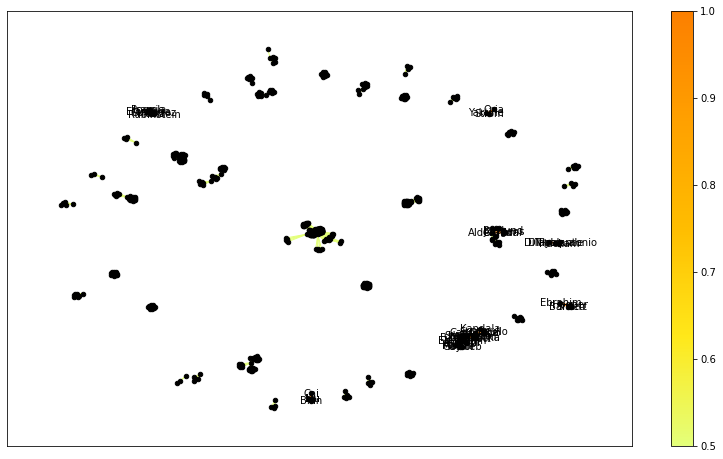

In [72]:
label_nodes = []

for e in G.edges():
    if G.get_edge_data(e[0],e[1])['review_percent'] >= 0.9:
        label_nodes.append(e[0])
        label_nodes.append(e[1])

label_nodes = list(set(label_nodes))
label_nodes

labels = {}

for node in G.nodes():
    if node in label_nodes:
        labels[node] = node.split(" ")[-1]

edges,weights = zip(*nx.get_edge_attributes(G,'review_percent').items())
    
pos = nx.spring_layout(G,scale = 100)
nodes = nx.draw_networkx_nodes(G, pos=pos,node_size = 20, node_color="black")
edges_1 = nx.draw_networkx_edges(G,pos=pos, edgelist=edges, edge_color=weights,  edge_cmap=plt.cm.Wistia)
nx.draw_networkx_labels(G, pos,labels,font_size=10,font_color='black')

# plt.Figure(figsize=(15,18))

plt.sci(edges_1)
plt.colorbar()

plt.rcParams["figure.figsize"] = [20, 20]
plt.rcParams["figure.autolayout"] = False

plt.savefig("graph_scale.pdf", dpi = 800)


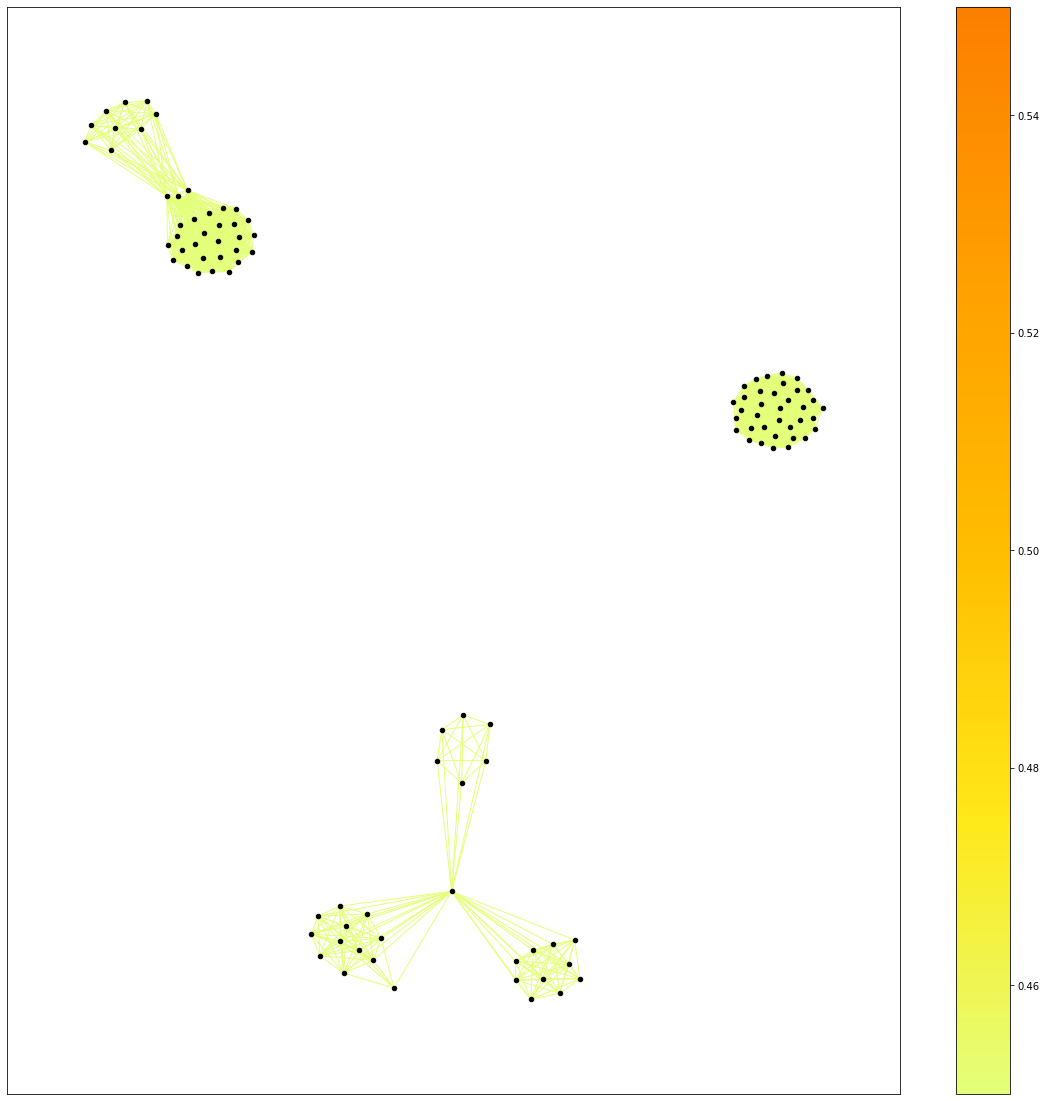

In [73]:
label_nodes = []

for e in N.edges():
    if N.get_edge_data(e[0],e[1])['weight'] >= 0.9:
        label_nodes.append(e[0])
        label_nodes.append(e[1])

label_nodes = list(set(label_nodes))
label_nodes

labels = {}

for node in N.nodes():
    if node in label_nodes:
        labels[node] = node.split(" ")[-1]

edges,weights = zip(*nx.get_edge_attributes(N,'weight').items())
    
pos = nx.spring_layout(N,scale = 100)
nodes = nx.draw_networkx_nodes(N, pos=pos,node_size = 20, node_color="black")
edges_1 = nx.draw_networkx_edges(N,pos=pos, edgelist=edges, edge_color=weights,  edge_cmap=plt.cm.Wistia)
nx.draw_networkx_labels(N, pos,labels,font_size=10,font_color='black')

# plt.Figure(figsize=(15,18))

plt.sci(edges_1)
plt.colorbar()

plt.rcParams["figure.figsize"] = [20, 20]
plt.rcParams["figure.autolayout"] = False

plt.savefig("graph_scale.pdf", dpi = 800)


In [78]:
#### node review article

new_auth  = {}
r_count = 0
i_count = 0
for i in range(1,len(merged_type_df)):
    name = merged_type_df["full_name"].loc[i]
    type_t = merged_type_df["item_type"].loc[i]
    if type_t == "Systematic Review":
        r_count = 1
    else:
        i_count = 1
    if len(name) >= 2:
        for subset in itertools.combinations(name,2):
            if len(subset) == 2:
                
                subset = tuple(sorted(subset))
                for i in subset:
                    if i not in new_auth.keys():
                        new_auth[i] = (r_count, i_count)
                    else:
                        new_auth[i] = (new_auth[i][0] + r_count, new_auth[i][1] + i_count)
                    

df_new = pd.DataFrame(new_auth.items(), columns=['authors','counts'])
df_new[['reviews', 'study']] = pd.DataFrame(df['counts'].tolist(), index=df.index)

df_new['total'] = df_new['reviews'] + df_new['study']
df_new['review'] = round(df_new['reviews']/df_new['total'],2)

df_attr_node = df_new[['authors','review']]
node_attr = df_attr_node.set_index('authors').to_dict('index')
nx.set_node_attributes(N, node_attr, name = "review_percent")

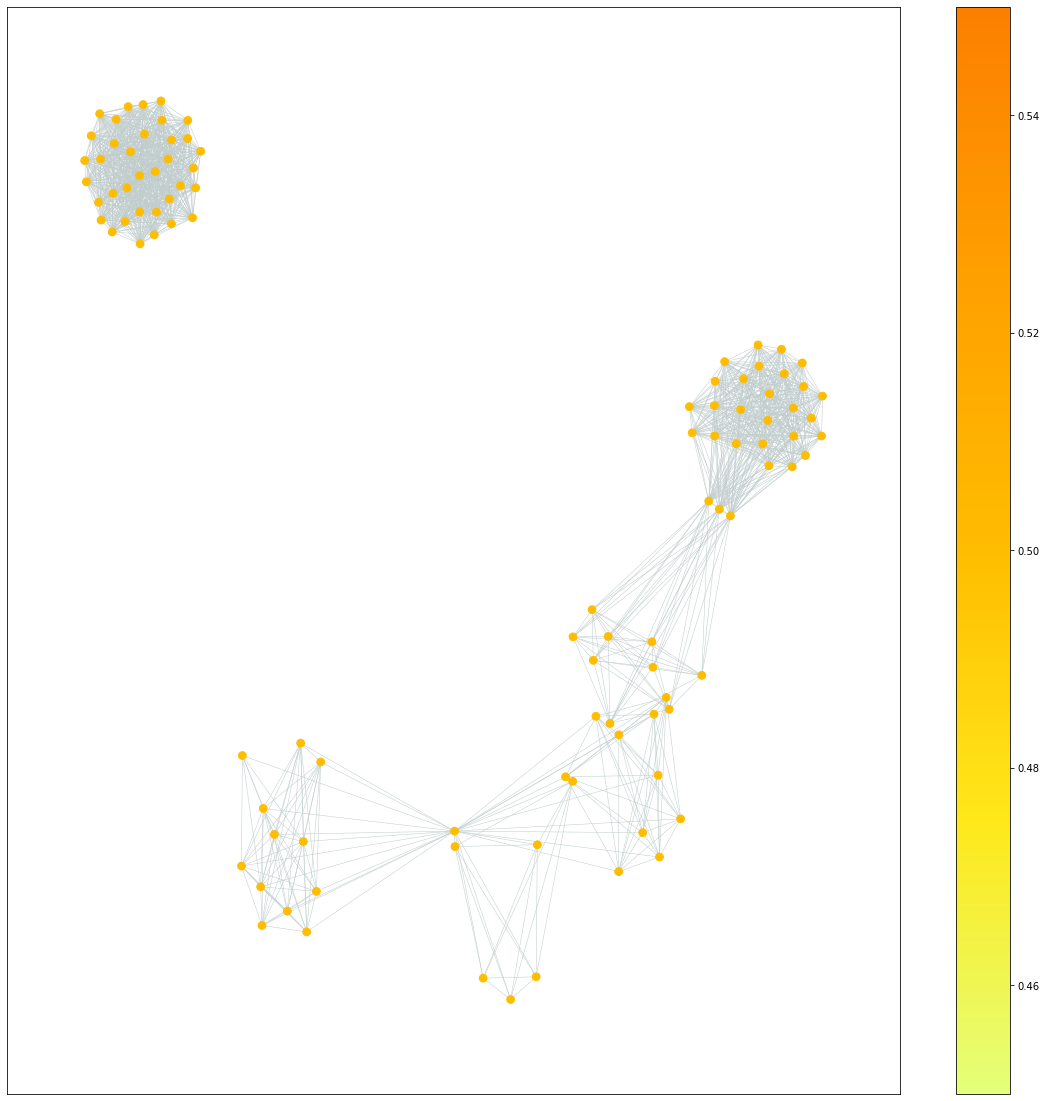

In [79]:
label_nodes = []

for n in N.nodes():
    if N.nodes[n]["review_percent"]['review'] >= 0.8:
        label_nodes.append(n)

label_nodes = list(set(label_nodes))
label_nodes

labels = {}

for node in N.nodes():
    if node in label_nodes:
        labels[node] = node.split(" ")[-1]

edges,weights = zip(*nx.get_edge_attributes(N,'weight').items())
nodes, r_pct = zip(*nx.get_node_attributes(N,'review_percent').items())

node_weight = []
for r in r_pct:
    node_weight.append(r['review'])

pos = nx.spring_layout(N, k=0.35, scale = 500)
nodes = nx.draw_networkx_nodes(N, pos=pos, nodelist=nodes, node_size=60, node_color=node_weight, cmap = plt.cm.Wistia)
edges_1 = nx.draw_networkx_edges(N,pos=pos, node_size = 10, width=weights, edgelist=edges, edge_color = '#C1CDCD')
nx.draw_networkx_labels(N, pos,labels,font_size=10,font_color='black')

# plt.Figure(figsize=(15,18))

plt.sci(nodes)
plt.colorbar()

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.autolayout"] = False

plt.savefig("graph_scale.pdf", dpi = 800)
